In [1]:
!conda install --yes matplotlib

Solving environment: done

# All requested packages already installed.



In [2]:
%matplotlib inline

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:

        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [5]:
TRAIN_PATH = "/datasets/food-101/train/"
VALID_PATH = "/datasets/food-101/test/"
bs = 32

In [6]:
food101_mean, food101_std = [0.5567, 0.4381, 0.3198], [0.2590, 0.2622, 0.2631]
print(food101_mean, food101_std)

[0.5567, 0.4381, 0.3198] [0.259, 0.2622, 0.2631]


In [7]:
train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(food101_mean, food101_std) #normalizing here 
        ])
        
valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(food101_mean, food101_std)  #normalizing here 
])
train_ds_full = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
lengths = [int(len(train_ds_full)*.7), int(len(train_ds_full)*.3)]
train_ds_holdout, train_ds = torch.utils.data.random_split(train_ds_full, lengths, generator=torch.Generator().manual_seed(42))
valid_ds = datasets.ImageFolder(root=VALID_PATH, transform=valid_tfms)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)

dataloaders = {"train": train_dl, "val": valid_dl}
dataset_sizes = {"train": len(train_ds), "val": len(valid_ds)}

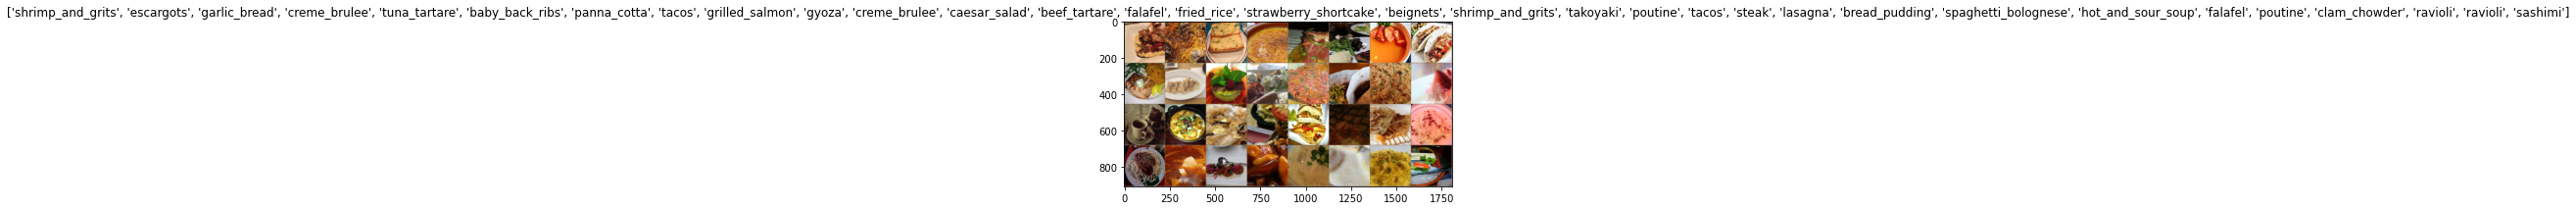

In [8]:
class_names = valid_ds.classes
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(food101_mean)
    std = np.array(food101_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.vgg16_bn(pretrained=True)
#num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=101)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUS!")
#     model_ft = nn.DataParallel(model_ft)
   

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=9, gamma=0.1)

In [12]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 3.0323 Acc: 0.2943
val Loss: 2.0858 Acc: 0.4758

Epoch 1/29
----------
train Loss: 2.0347 Acc: 0.4884
val Loss: 1.7960 Acc: 0.5412

Epoch 2/29
----------
train Loss: 1.7734 Acc: 0.5472
val Loss: 1.6641 Acc: 0.5672

Epoch 3/29
----------
train Loss: 1.6220 Acc: 0.5854
val Loss: 1.5858 Acc: 0.5905

Epoch 4/29
----------
train Loss: 1.4923 Acc: 0.6151
val Loss: 1.5169 Acc: 0.6038

Epoch 5/29
----------
train Loss: 1.3953 Acc: 0.6362
val Loss: 1.5049 Acc: 0.6056

Epoch 6/29
----------
train Loss: 1.3211 Acc: 0.6541
val Loss: 1.4804 Acc: 0.6116

Epoch 7/29
----------
train Loss: 1.2628 Acc: 0.6708
val Loss: 1.4337 Acc: 0.6221

Epoch 8/29
----------
train Loss: 1.1954 Acc: 0.6841
val Loss: 1.3917 Acc: 0.6380

Epoch 9/29
----------
train Loss: 1.0376 Acc: 0.7237
val Loss: 1.2657 Acc: 0.6651

Epoch 10/29
----------
train Loss: 0.9981 Acc: 0.7330
val Loss: 1.2400 Acc: 0.6720

Epoch 11/29
----------
train Loss: 0.9550 Acc: 0.7509
val Loss: 1.2620 Acc: 0.6663

Ep

In [13]:
torch.save(model_ft.state_dict(), 'vgg16_food101.pt')